In [29]:
from Phase_4_functions import roll_mean_std
from Phase_4_functions import decompose
from Phase_4_functions import DickeyFullerTest
from Phase_4_functions import naive_model
from Phase_4_functions import sarimax_search
from Phase_4_functions import fbprophet_func
from Phase_4_functions import LSTM_func
from Phase_4_functions import LSTM_val

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from fbprophet import Prophet as proph

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('data/new_zillow_data.csv')

In [3]:
def melt_data(df):
    """
    Takes the zillow_data dataset in wide form or a subset of the zillow_dataset.  
    Returns a long-form datetime dataframe 
    with the datetime column names as the index and the values as the 'values' column.
    
    If more than one row is passes in the wide-form dataset, the values column
    will be the mean of the values from the datetime columns in all of the rows.
    """
    
    melted = pd.melt(df, id_vars=['RegionName', 'RegionID', 'SizeRank', 'City', 'State', 
                                  'Metro', 'CountyName', 'RegionType', 'StateName'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
melted = melt_data(df)
melted['time'] = pd.to_datetime(melted['time'])
melted.set_index('time', inplace=True)

## Zip Code 84045 (Saratoga Springs, UT)

### Plot the Rolling Mean and Rolling Std.

In [5]:
Saratoga = melted[melted.RegionName == 84045]
Saratoga = Saratoga.resample('MS').mean()
Saratoga = Saratoga.drop(['RegionName', 'RegionID', 'SizeRank'], axis=1)

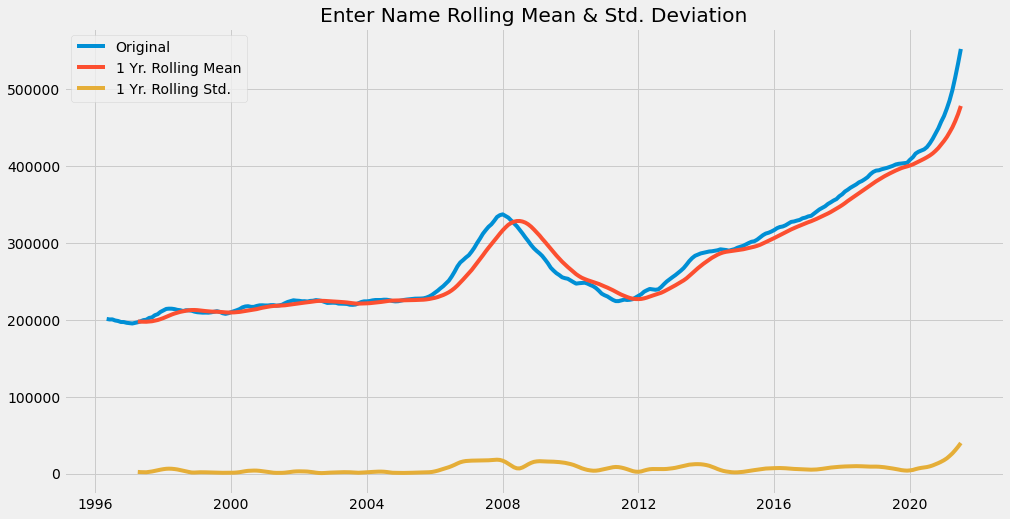

In [6]:
roll_mean_std(Saratoga)

### Seasonal Decompose

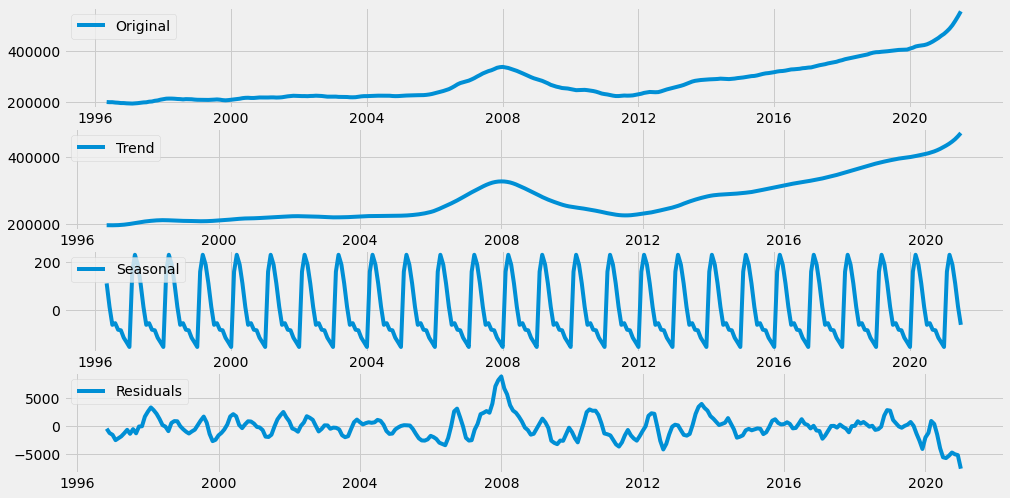

In [7]:
decompose(Saratoga)

### Differencing and DickeyFuller Test

In [8]:
DickeyFullerTest(Saratoga)

Test Statistic                   2.329205
p-value                          0.998973
# Lags Used                     16.000000
Number of Observations Used    286.000000
Critical Value (1%)             -3.453423
Critical Value (5%)             -2.871699
Critical Value (10%)            -2.572183
dtype: float64

Test Statistic                  -0.721139
p-value                          0.841198
# Lags Used                     16.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64

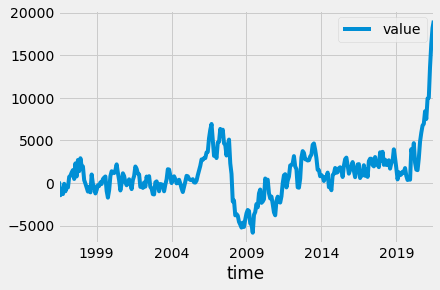

In [9]:
Saratoga_diff = Saratoga.diff().dropna()
Saratoga_diff.plot()
DickeyFullerTest(Saratoga_diff)

Test Statistic                  -2.565152
p-value                          0.100416
# Lags Used                     15.000000
Number of Observations Used    285.000000
Critical Value (1%)             -3.453505
Critical Value (5%)             -2.871735
Critical Value (10%)            -2.572202
dtype: float64

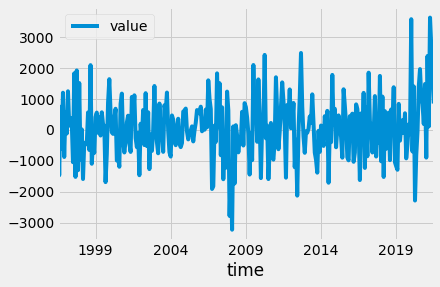

In [10]:
Saratoga_diff2 = Saratoga_diff.diff().dropna()
Saratoga_diff2.plot()
DickeyFullerTest(Saratoga_diff2)

Test Statistic                  -5.324884
p-value                          0.000005
# Lags Used                     16.000000
Number of Observations Used    283.000000
Critical Value (1%)             -3.453670
Critical Value (5%)             -2.871808
Critical Value (10%)            -2.572241
dtype: float64

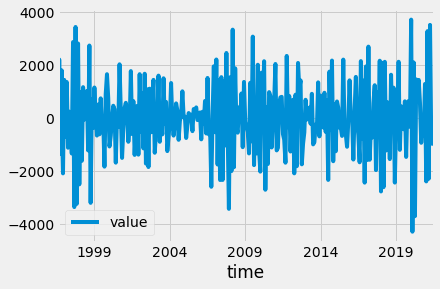

In [11]:
Saratoga_diff3 = Saratoga_diff2.diff().dropna()
Saratoga_diff3.plot()
DickeyFullerTest(Saratoga_diff3)

### ACF and PACF

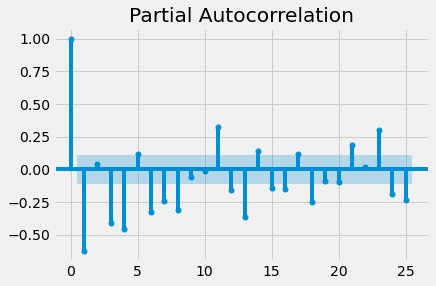

In [12]:
plot_pacf(Saratoga_diff3);

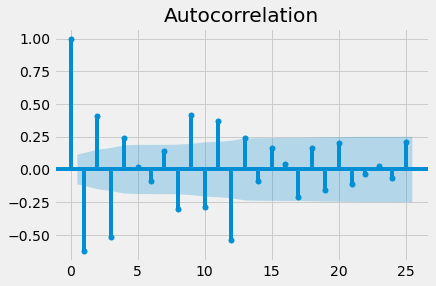

In [13]:
plot_acf(Saratoga_diff3);

### Train Test Split

In [14]:
cutoff = round(Saratoga.shape[0]*.8)
train = Saratoga[:cutoff]
test = Saratoga[cutoff:]

### Naive Model

The Naive Model RMSE for the train data is: 2301.1
The Naive Model RMSE for the test data is: 5587.37


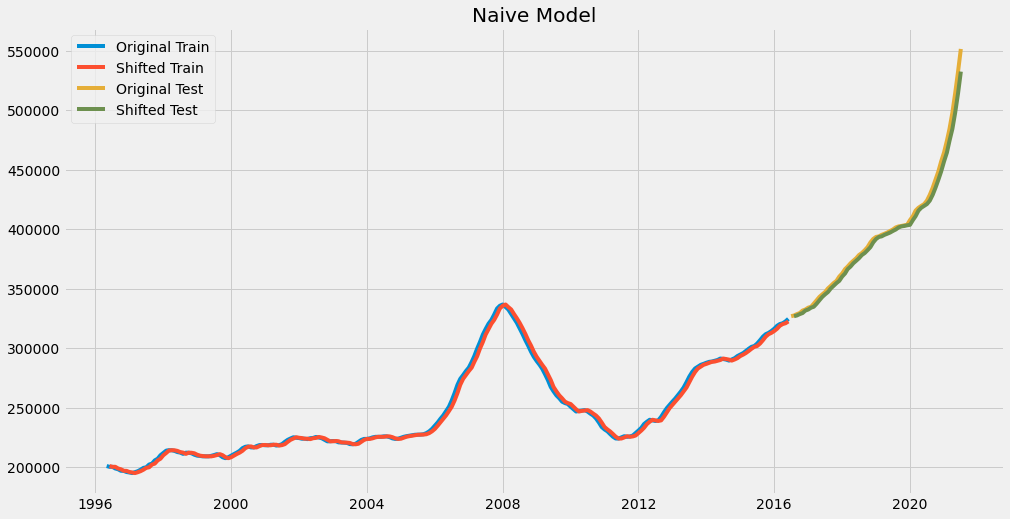

In [15]:
naive_model(train, test)

### SARIMAX GridSearch and Model

In [16]:
sarimax_search(train, p=range(1,3), d=range(1,4), q=range(1,3), maxiter=100)

THERE ARE 144 ITERATIONS
Would you like to run the models? (y or n)?n
OK, SARIMAX models will not be run.


### Facebook Prophet Model

In [17]:
Saratoga_proph = Saratoga.reset_index()
Saratoga_proph = Saratoga_proph.rename(columns={'time':'ds', 'value':'y'})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


RMSE for the train data: 4208.179414054539
%RMSE:  y    0.015207
dtype: float64


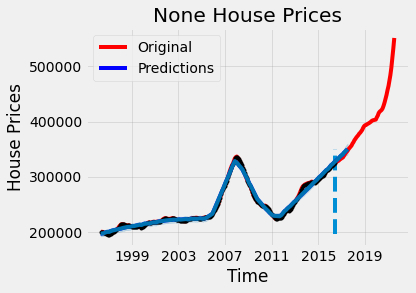

In [18]:
fbprophet_func(Saratoga_proph)

### LSTM Model

In [19]:
history = LSTM_func(Saratoga_proph, City=Saratoga, epochs=20)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 64)             16896     
_________________________________________________________________
lstm_1 (LSTM)                (None, 5, 32)             12416     
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 32,465
Trainable params: 32,465
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
48/48 [==============================] - 1s 26ms/step - loss: 0.7470 - val_loss: 245.5965
Epoch 2/20
48/48 

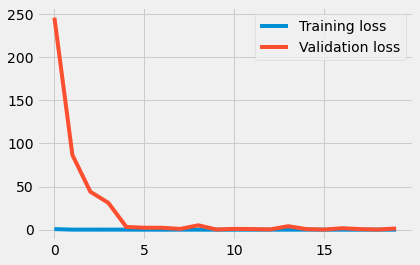

In [20]:
LSTM_val(history)

In [21]:
Saratoga_proph

,ds,y
0,1996-05-01,200850.0
1,1996-06-01,200187.0
2,1996-07-01,200241.0
3,1996-08-01,198823.0
4,1996-09-01,198150.0
...,...,...
298,2021-03-01,484424.0
299,2021-04-01,498070.0
300,2021-05-01,514395.0
301,2021-06-01,532593.0


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


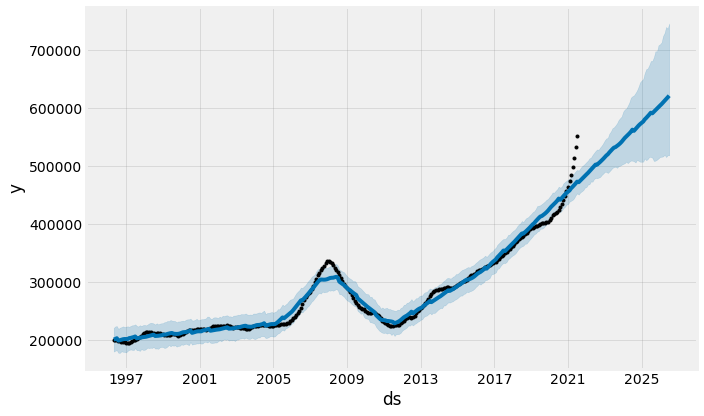

In [22]:
final_model = proph(interval_width=.95)
final_model.fit(Saratoga_proph)
future_dates = final_model.make_future_dataframe(periods=60, freq='MS')
forecast = final_model.predict(future_dates)
final_model.plot(forecast, uncertainty=True);

In [31]:
Saratoga_proph

,ds,y
0,1996-05-01,200850.0
1,1996-06-01,200187.0
2,1996-07-01,200241.0
3,1996-08-01,198823.0
4,1996-09-01,198150.0
...,...,...
298,2021-03-01,484424.0
299,2021-04-01,498070.0
300,2021-05-01,514395.0
301,2021-06-01,532593.0


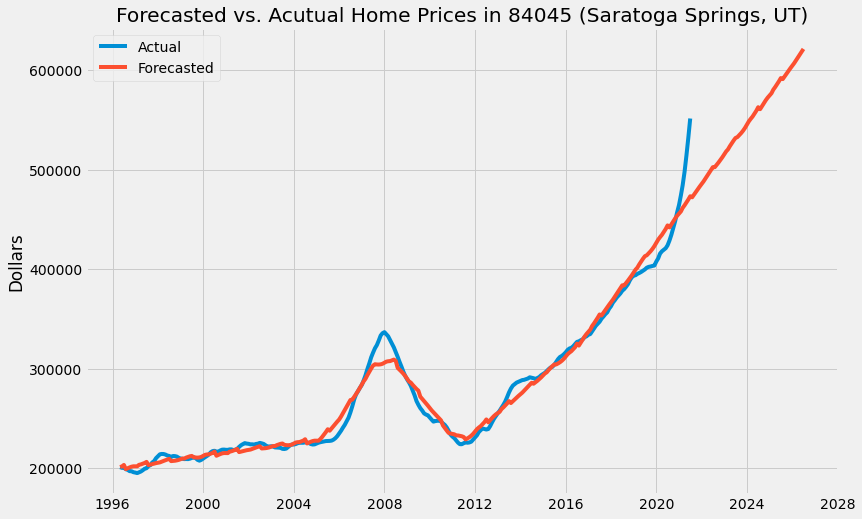

In [37]:
fig, ax = plt.subplots(figsize=(12,8))
ax.plot(Saratoga_proph.ds, Saratoga_proph.y, label='Actual')
ax.plot(forecast.ds, forecast.yhat, label='Forecasted')
ax.set_title('Forecasted vs. Acutual Home Prices in 84045 (Saratoga Springs, UT)')
ax.set_ylabel('Dollars')
ax.legend();

In [71]:
current_price = int(Saratoga_proph[Saratoga_proph.ds == '2021-07-01'].y.values)
predicted_price = int(forecast[forecast.ds == '2026-07-01'].yhat.values)
pred_five_year_increase = predicted_price - current_price
five_year_roi = pred_five_year_increase / current_price
print(f'Current price:                ${current_price}')
print(f'Predicted 2026 price:         ${predicted_price}')
print(f'Predicted five year increase: ${pred_five_year_increase}')
print(f'Predicted five year ROI:      {five_year_roi}')

Current price:                $551641
Predicted 2026 price:         $621613
Predicted five year increase: $69972
Predicted five year ROI:      0.12684336370936897


In [62]:
Saratoga_proph[Saratoga_proph.ds == '2021-07-01'].y.values

array([551641.])

In [58]:
forecast[forecast.ds == '2026-07-01'].yhat.values

array([621613.55118097])